# Cifar10 Pipeline

## Prequisites

#### Following dependent packages needs to be installed before running the build script

1. kfp - `! pip install git+https://github.com/kubeflow/pipelines.git#subdirectory=sdk/python`
2. docker - should be logged in using docker login
3. yq - install using snap - https://github.com/mikefarah/yq
4. jq - v1.6 - https://stedolan.github.io/jq/download/

#### ./build.sh takes two arguments

1. path to example - For ex: examples/cifar10
2. dockerhub username - For ex: shrinathsuresh


## Install packages

In [83]:
!pip install captum torchvision matplotlib pillow flask flask_compress

     |████████████████████████████████| 357 kB 435 kB/s eta 0:00:01


**Make sure the current working directory is "pytorch_pipeline"**

In [98]:
import os
os.getcwd()

'/home/ubuntu/Repositories/fb/pytorch-pipeline/pytorch_pipeline'

## Generate Pipeline file

In [24]:
! ./build.sh examples/cifar10 jagadeeshj

++++ Building component images with tag=17-05-2021-18-03-19.795260
IMAGE TO BUILD: jagadeeshj/pytorch_pipeline:17-05-2021-18-03-19.795260
Sending build context to Docker daemon  9.357MB
Step 1/9 : FROM pytorch/pytorch:latest
 ---> 5ffed6c83695
Step 2/9 : COPY requirements.txt requirements.txt
 ---> Using cache
 ---> 89dbbc29d83f
Step 3/9 : RUN apt-get update
 ---> Using cache
 ---> 0973ae1700b3
Step 4/9 : RUN apt-get install -y git
 ---> Using cache
 ---> d77abb2b673d
Step 5/9 : RUN git clone -b main https://github.com/chauhang/pytorch-pipeline
 ---> Using cache
 ---> df292fcd885d
Step 6/9 : RUN pip3 install -r requirements.txt
 ---> Using cache
 ---> 24e900925cfc
Step 7/9 : ENV PYTHONPATH /workspace/pytorch-pipeline
 ---> Using cache
 ---> f4e61988af23
Step 8/9 : WORKDIR /workspace/pytorch-pipeline
 ---> Using cache
 ---> d7d8f645375b
Step 9/9 : ENTRYPOINT /bin/bash
 ---> Using cache
 ---> 318ed7bd4a08
Successfully built 318ed7bd4a08
Successfully tagged jagadeeshj/pytorch_pipeline:17-

## At the end of this step - pytorch_cifar10.yaml file will be generated

In [72]:
import kfp
import json
import os
from PIL import Image
from kfp import components
from kfp.components import load_component_from_file, load_component_from_url
from kfp import dsl
from kfp import compiler
from pathlib import Path

kfp.__version__

'1.6.0-rc.0'

# Enter your KFP URL and the token from the cookie
[Use this extension on chrome to get token]( https://chrome.google.com/webstore/detail/editthiscookie/fngmhnnpilhplaeedifhccceomclgfbg?hl=en)
![image.png](image.png)

## Set Pipeline URL, Cookie, Experiment and Namespac

In [163]:
# KFP_URL='istio-ingressgateway.istio-system.svc.cluster.local'
KFP_URL='http://localhost:8080'
COOKIE="MTYyMTIzNTI4M3xOd3dBTkVaVVNGUTNSMVJIVFZVM1NsTTJWVm8zUlZOTlFVOU9Na2N6V1VzeVZVeFFOazgwV0U1SVFsSldURXBVVjBGWVVVYzJXVkU9fDruba4Uy-aLX2gbaxSW4OWIDQhcsvCKYdfCjZWw0I4o"
AUTH="authservice_session="+COOKIE
NAMESPACE="kubeflow-user-example-com"
EXPERIMENT="Default"

## Set Log bucket and Tensorboard Image

In [164]:
MINIO_ENDPOINT="http://minio-service.kubeflow:9000"
LOG_BUCKET="mlpipeline"
TENSORBOARD_IMAGE="jagadeeshj/tb_plugin:v1.8"

## Set Inference parameters

In [162]:
MODEL_NAME="cifar10"
DEPLOY_NAME="torchserve"
ISVC_NAME=DEPLOY_NAME+"."+NAMESPACE+"."+"example.com"
INFERENCE_URL="http://istio-ingressgateway.istio-system.svc.cluster.local"
INPUT_REQUEST="https://kubeflow-dataset.s3.us-east-2.amazonaws.com/cifar10_input/input.json"

## Create KFP Client and create an experiment

In [55]:
client = kfp.Client(host=KFP_URL+"/pipeline", cookies=AUTH)
client.create_experiment(name=EXPERIMENT, namespace=NAMESPACE)
experiments = client.list_experiments(namespace=NAMESPACE)
my_experiment = experiments.experiments[0]
my_experiment

{'created_at': datetime.datetime(2021, 4, 22, 8, 44, 39, tzinfo=tzutc()),
 'description': None,
 'id': 'aac96a63-616e-4d88-9334-6ca8df2bb956',
 'name': 'Default',
 'resource_references': [{'key': {'id': 'kubeflow-user-example-com',
                                  'type': 'NAMESPACE'},
                          'name': None,
                          'relationship': 'OWNER'}],
 'storage_state': 'STORAGESTATE_AVAILABLE'}

## Pipeline params

In [100]:
pipeline_params = {
    "minio_endpoint" : MINIO_ENDPOINT,
    "tf_image" : TENSORBOARD_IMAGE,
    "log_bucket" : LOG_BUCKET,
    "input_req" : INPUT_REQUEST,
    "cookie" :  COOKIE,
    "ingress_gateway" : INFERENCE_URL,
    "isvc_name" : ISVC_NAME,
    "deploy" : DEPLOY_NAME,
    "model" : MODEL_NAME,
    "namespace" : NAMESPACE,
}

## Click on Run Details for navigating to pipeline

In [59]:
run_name = 'pytorch-cifar10'
# Execute pipeline
run = client.run_pipeline(my_experiment.id, run_name, "pytorch_cifar10.yaml", pipeline_params)

## Get Inference service name

In [158]:
INFERENCE_SERVICE_LIST = ! kubectl get isvc $DEPLOY_NAME -n kubeflow-user-example-com -o json | jq .status.url | tr -d '"'| cut -d "/" -f 3
INFERENCE_SERVICE_NAME = INFERENCE_SERVICE_LIST[0]
INFERENCE_SERVICE_NAME

'torchserve.kubeflow-user-example-com.example.com'

In [159]:
!curl -v -H "Host: $INFERENCE_SERVICE_NAME" -H "Cookie: $AUTH" "$KFP_URL/v1/models/$MODEL_NAME:predict" -d @./examples/cifar10/input.json > cifar10_prediction_output.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0*   Trying 127.0.0.1:8080...
* TCP_NODELAY set
* Connected to localhost (127.0.0.1) port 8080 (#0)
> POST /v1/models/cifar10:predict HTTP/1.1
> Host: torchserve.kubeflow-user-example-com.example.com
> User-Agent: curl/7.68.0
> Accept: */*
> Cookie: authservice_session=MTYyMTIzNTI4M3xOd3dBTkVaVVNGUTNSMVJIVFZVM1NsTTJWVm8zUlZOTlFVOU9Na2N6V1VzeVZVeFFOazgwV0U1SVFsSldURXBVVjBGWVVVYzJXVkU9fDruba4Uy-aLX2gbaxSW4OWIDQhcsvCKYdfCjZWw0I4o
> Content-Length: 148025
> Content-Type: application/x-www-form-urlencoded
> Expect: 100-continue
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 100 Continue
  0  144k    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0} [65536 bytes data]
* We are completely uploaded and fine
100  144k    0     0  100  144k

In [62]:
! cat cifar10_prediction_output.json

{"predictions": [{"1": 0.4704199731349945, "9": 0.43275219202041626, "6": 0.059682123363018036, "0": 0.01471410971134901, "3": 0.011092518456280231}]}

In [63]:
!curl -v -H "Host: $INFERENCE_SERVICE_NAME" -H "Cookie: $AUTH" "$KFP_URL/v1/models/$MODEL_NAME:explain" -d @./examples/cifar10/input.json > cifar10_explanation_output.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0*   Trying 127.0.0.1:8080...
* TCP_NODELAY set
* Connected to localhost (127.0.0.1) port 8080 (#0)
> POST /v1/models/cifar10:explain HTTP/1.1
> Host: torchserve.kubeflow-user-example-com.example.com
> User-Agent: curl/7.68.0
> Accept: */*
> Cookie: authservice_session=MTYyMTIzNTI4M3xOd3dBTkVaVVNGUTNSMVJIVFZVM1NsTTJWVm8zUlZOTlFVOU9Na2N6V1VzeVZVeFFOazgwV0U1SVFsSldURXBVVjBGWVVVYzJXVkU9fDruba4Uy-aLX2gbaxSW4OWIDQhcsvCKYdfCjZWw0I4o
> Content-Length: 148025
> Content-Type: application/x-www-form-urlencoded
> Expect: 100-continue
> 
* Done waiting for 100-continue
  0  144k    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0} [65536 bytes data]
* We are completely uploaded and fine
* Mark bundle as not supporting multiuse
< HTTP/1.1 100 Continue

In [1]:
#! head -5 cifar10_explanation_output.json

In [65]:
import json
explainations_json = json.loads(open("./cifar10_explanation_output.json", "r").read())
attributions = explainations_json['explanations']

In [66]:
prediction_json = json.loads(open("./cifar10_prediction_output.json", "r").read())
prediction_json["predictions"][0]


{'1': 0.4704199731349945,
 '9': 0.43275219202041626,
 '6': 0.059682123363018036,
 '0': 0.01471410971134901,
 '3': 0.011092518456280231}

In [86]:
import json
import os
import logging
import numpy as np


from PIL import Image
import torchvision.transforms as transforms


from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt


import torch
import torch.nn.functional as F

import captum
from captum.attr import NoiseTunnel
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

from examples.cifar10.cifar10_train  import CIFAR10Classifier

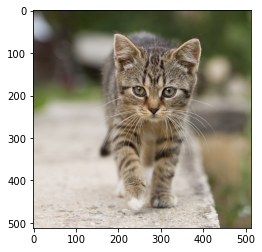

In [87]:
#Read the test image
test_img = Image.open('./examples/cifar10/kitten.png')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()


In [88]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

In [89]:
labels_path = './examples/cifar10/class_mapping.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data) 
list(map(lambda k: idx_to_labels[k], idx_to_labels.keys()))

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [220]:
minio_config = {
            "HOST": "localhost:9000",
            "ACCESS_KEY": "minio",
            "SECRET_KEY": "minio123",
            "BUCKET": "mlpipeline",
            "FOLDER": " modelfiles/cifar10/902a2a9e-9739-42dc-b41f-81c5dd5a4864"}

def _initiate_minio_client(minio_config):
        minio_host = minio_config["HOST"]
        access_key = minio_config["ACCESS_KEY"]
        secret_key = minio_config["SECRET_KEY"]
        client = Minio(minio_host, access_key=access_key, secret_key=secret_key, secure=False)
        return client

client= _initiate_minio_client(minio_config)
client

In [222]:
def download_artifact_from_minio(folder: str, artifact: str):
        artifact_name = artifact.split("/")[-1]
        result = client.fget_object(
            minio_config["BUCKET"],
            os.path.join(folder, artifact_name),
            artifact,
        )
        print(result)      


In [223]:
download_artifact_from_minio("modelfiles/cifar10/902a2a9e-9739-42dc-b41f-81c5dd5a4864","resnet.pth")

In [90]:
model = CIFAR10Classifier()
model_pt_path ="./resnet.pth"
model.load_state_dict(torch.load(model_pt_path,map_location=torch.device('cpu')))
model.eval()

CIFAR10Classifier(
  (model_conv): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

#### Captum Vis and Insights

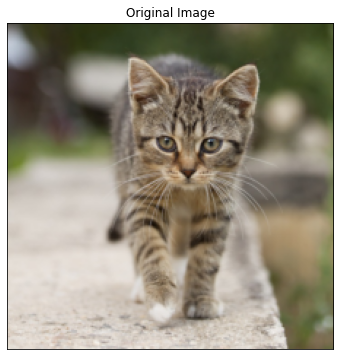

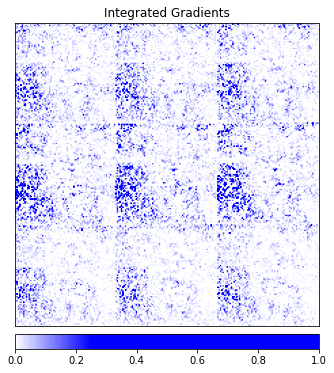

In [91]:
# Show the original image for comparison
#np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0))
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)), 
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(attributions,
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

In [92]:
imgs = ['./examples/cifar10/kitten.png',"./examples/cifar10/horse.png"]

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.squeeze_().item())]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

Predicted: cat / 3  ( 0.18024620413780212 )
Predicted: horse / 7  ( 0.15090999007225037 )


In [93]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    i.requires_grad = True
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[3,7])]
)

In [94]:
visualizer.render(debug =True)

CaptumInsights(insights_config={'classes': ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'sh…

Output()

In [71]:
visualizer.render(debug=True)

CaptumInsights(insights_config={'classes': ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'sh…

Output()

In [86]:
import json
import os
import logging
import numpy as np


from PIL import Image
import torchvision.transforms as transforms


from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt


import torch
import torch.nn.functional as F

import captum
from captum.attr import NoiseTunnel
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

from examples.cifar10.cifar10_train  import CIFAR10Classifier

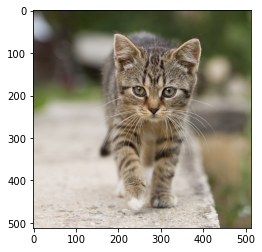

In [87]:
#Read the test image
test_img = Image.open('./examples/cifar10/kitten.png')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()


In [88]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

In [89]:
labels_path = './examples/cifar10/class_mapping.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data) 
list(map(lambda k: idx_to_labels[k], idx_to_labels.keys()))

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [220]:
minio_config = {
            "HOST": "localhost:9000",
            "ACCESS_KEY": "minio",
            "SECRET_KEY": "minio123",
            "BUCKET": "mlpipeline",
            "FOLDER": " modelfiles/cifar10/902a2a9e-9739-42dc-b41f-81c5dd5a4864"}

def _initiate_minio_client(minio_config):
        minio_host = minio_config["HOST"]
        access_key = minio_config["ACCESS_KEY"]
        secret_key = minio_config["SECRET_KEY"]
        client = Minio(minio_host, access_key=access_key, secret_key=secret_key, secure=False)
        return client

client= _initiate_minio_client(minio_config)
client

In [222]:
def download_artifact_from_minio(folder: str, artifact: str):
        artifact_name = artifact.split("/")[-1]
        result = client.fget_object(
            minio_config["BUCKET"],
            os.path.join(folder, artifact_name),
            artifact,
        )
        print(result)      


In [223]:
download_artifact_from_minio("modelfiles/cifar10/902a2a9e-9739-42dc-b41f-81c5dd5a4864","resnet.pth")

In [90]:
model = CIFAR10Classifier()
model_pt_path ="./resnet.pth"
model.load_state_dict(torch.load(model_pt_path,map_location=torch.device('cpu')))
model.eval()

CIFAR10Classifier(
  (model_conv): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

#### Captum Vis and Insights

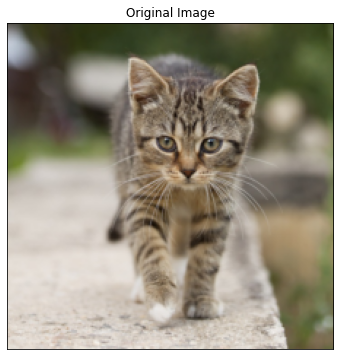

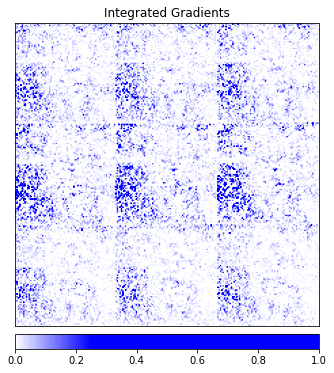

In [91]:
# Show the original image for comparison
#np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0))
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)), 
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(attributions,
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

In [92]:
imgs = ['./examples/cifar10/kitten.png',"./examples/cifar10/horse.png"]

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.squeeze_().item())]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

Predicted: cat / 3  ( 0.18024620413780212 )
Predicted: horse / 7  ( 0.15090999007225037 )


In [93]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    i.requires_grad = True
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[3,7])]
)

In [94]:
visualizer.render(debug =True)

CaptumInsights(insights_config={'classes': ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'sh…

Output()

In [71]:
visualizer.render(debug=True)

CaptumInsights(insights_config={'classes': ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'sh…

Output()

In [86]:
import json
import os
import logging
import numpy as np


from PIL import Image
import torchvision.transforms as transforms


from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt


import torch
import torch.nn.functional as F

import captum
from captum.attr import NoiseTunnel
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

from examples.cifar10.cifar10_train  import CIFAR10Classifier

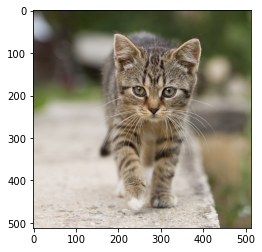

In [87]:
#Read the test image
test_img = Image.open('./examples/cifar10/kitten.png')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()


In [88]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

In [89]:
labels_path = './examples/cifar10/class_mapping.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data) 
list(map(lambda k: idx_to_labels[k], idx_to_labels.keys()))

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [220]:
minio_config = {
            "HOST": "localhost:9000",
            "ACCESS_KEY": "minio",
            "SECRET_KEY": "minio123",
            "BUCKET": "mlpipeline",
            "FOLDER": " modelfiles/cifar10/902a2a9e-9739-42dc-b41f-81c5dd5a4864"}

def _initiate_minio_client(minio_config):
        minio_host = minio_config["HOST"]
        access_key = minio_config["ACCESS_KEY"]
        secret_key = minio_config["SECRET_KEY"]
        client = Minio(minio_host, access_key=access_key, secret_key=secret_key, secure=False)
        return client

client= _initiate_minio_client(minio_config)
client

In [222]:
def download_artifact_from_minio(folder: str, artifact: str):
        artifact_name = artifact.split("/")[-1]
        result = client.fget_object(
            minio_config["BUCKET"],
            os.path.join(folder, artifact_name),
            artifact,
        )
        print(result)      


In [223]:
download_artifact_from_minio("modelfiles/cifar10/902a2a9e-9739-42dc-b41f-81c5dd5a4864","resnet.pth")

In [90]:
model = CIFAR10Classifier()
model_pt_path ="./resnet.pth"
model.load_state_dict(torch.load(model_pt_path,map_location=torch.device('cpu')))
model.eval()

CIFAR10Classifier(
  (model_conv): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

#### Captum Vis and Insights

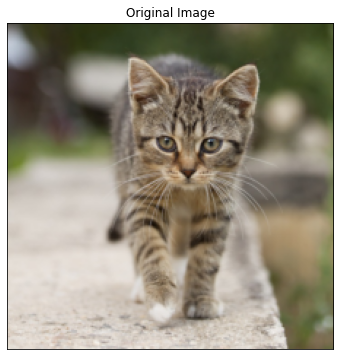

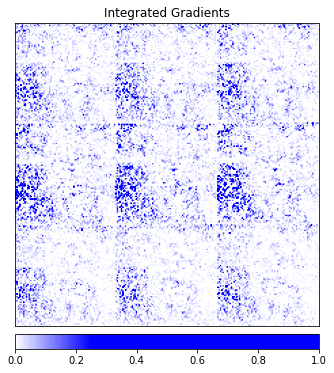

In [91]:
# Show the original image for comparison
#np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0))
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)), 
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(attributions,
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

In [92]:
imgs = ['./examples/cifar10/kitten.png',"./examples/cifar10/horse.png"]

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.squeeze_().item())]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

Predicted: cat / 3  ( 0.18024620413780212 )
Predicted: horse / 7  ( 0.15090999007225037 )


In [93]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    i.requires_grad = True
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[3,7])]
)

In [94]:
visualizer.render(debug =True)

CaptumInsights(insights_config={'classes': ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'sh…

Output()

In [71]:
visualizer.render(debug=True)

CaptumInsights(insights_config={'classes': ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'sh…

Output()

## Clean up
### Delete Viewers, Inference Services and Completed pods

In [167]:
! kubectl delete --all viewers -n $NAMESPACE

viewer.kubeflow.org "viewer-0a2171acce1d3ab74dcc22cc0f6e3b1b5b868916" deleted
viewer.kubeflow.org "viewer-2387e6cf111cbda7117831c1b49eca96b0aecdcf" deleted
viewer.kubeflow.org "viewer-2a62fd9b2208a0cb082124c0632525aa68e90494" deleted
viewer.kubeflow.org "viewer-2c39735d6b46d6ecb06524bb1b09e61213e19747" deleted
viewer.kubeflow.org "viewer-5d9d86c4bcfc77b31f5363d84c2ef05f8f0a97fd" deleted
viewer.kubeflow.org "viewer-62908d72b0084dee176271bfb395105a7fc1219b" deleted
viewer.kubeflow.org "viewer-76ef7e33e224e6f5b579c5d0361627c51109acec" deleted
viewer.kubeflow.org "viewer-a5e7fce5ad270e16df9a15fd7a1ddd1c2738b5d5" deleted
viewer.kubeflow.org "viewer-c5523e8aeb58c801f1b64a702367658debe6d402" deleted
viewer.kubeflow.org "viewer-c6ec6526eaf0244a536116dc6d7db62d1e9ac021" deleted
viewer.kubeflow.org "viewer-f55024e87d5d56e541b30712cb9e690dc9609b6f" deleted


In [168]:
! kubectl delete --all isvc -n $NAMESPACE

inferenceservice.serving.kubeflow.org "bertserve" deleted
inferenceservice.serving.kubeflow.org "mnist-ax" deleted
inferenceservice.serving.kubeflow.org "torchserve" deleted


In [ ]:
! kubectl delete pod --field-selector=status.phase==Succeeded -n $NAMESPACE